In [65]:
!nvidia-smi

Tue Nov 11 21:57:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P0             27W /   70W |    8310MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [66]:
!unzip /content/Bones-data.zip

Archive:  /content/Bones-data.zip
replace Bones-data/test/Oblique fracture/0-_gallery_jpeg.rf.b3170266ea6b6d03bfb4ae5991df98ce.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [67]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [68]:
size = [224, 224] + [3]
size

[224, 224, 3]

In [69]:
train_path = '/content/Bones-data/train'
valid_path = '/content/Bones-data/test'

In [70]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten

In [71]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3],  weights='imagenet', include_top=False)

In [72]:
for layer in vgg16.layers:
  print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [73]:
for layer in vgg16.layers:
    layer.trainable = False

In [74]:
for layer in vgg16.layers:
  print(layer.name,layer.trainable)

input_layer_5 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [75]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [76]:
folders = glob('/content/Bones-data/train/*')
folders

['/content/Bones-data/train/Oblique fracture',
 '/content/Bones-data/train/Spiral Fracture']

In [77]:
num_of_class = len(folders)
num_of_class

2

In [78]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze VGG16 layers
for layer in vgg16.layers:
    layer.trainable = False

# Build custom model on top of VGG16
x = vgg16.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_of_class, activation='softmax')(x)

model = Model(inputs=vgg16.input, outputs=output)


In [79]:
# model = Sequential()
# model.add(vgg16)
# model.add(Flatten())
# model.add(Dense(256,activation='relu'))
# model.add(Dense(num_of_class,activation='softmax'))

In [80]:
# view the structure of the model
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [81]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [83]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [84]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 143 images belonging to 2 classes.


In [85]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 28 images belonging to 2 classes.


In [86]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 881ms/step - accuracy: 0.4994 - loss: 5.5388 - val_accuracy: 0.4286 - val_loss: 4.3118
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.5307 - loss: 2.0902 - val_accuracy: 0.6071 - val_loss: 0.8665
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 0.6563 - loss: 1.3560 - val_accuracy: 0.5357 - val_loss: 1.9177
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - accuracy: 0.5955 - loss: 1.1768 - val_accuracy: 0.6071 - val_loss: 1.2769
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - accuracy: 0.6893 - loss: 0.7803 - val_accuracy: 0.5714 - val_loss: 1.3777
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - accuracy: 0.7739 - loss: 0.4904 - val_accuracy: 0.4286 - val_loss: 1.0333
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - accuracy: 0.8147 - loss: 0.3558 - val_accuracy: 0.3929 - val_loss: 1.0705
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step - accuracy: 0.8603 - loss: 0.3165 - val_accuracy: 0.5714 - val_loss:

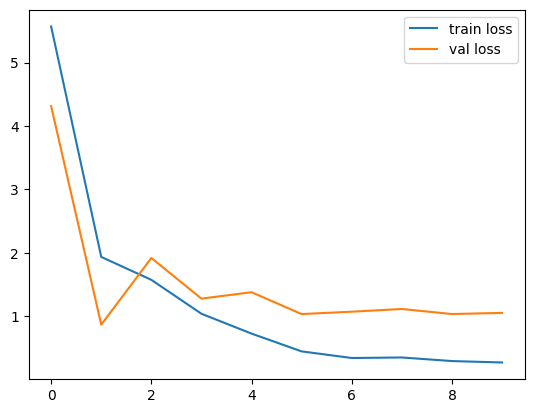

<Figure size 640x480 with 0 Axes>

In [87]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

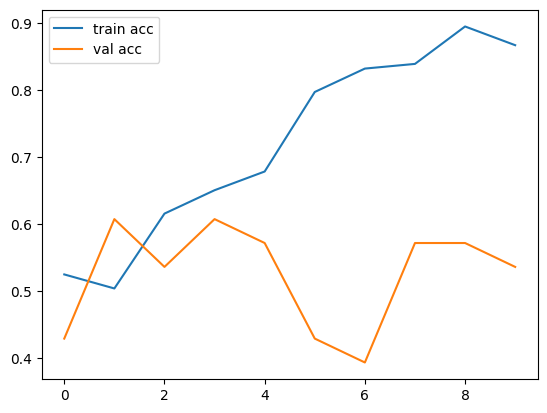

<Figure size 640x480 with 0 Axes>

In [88]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [89]:
model.evaluate(test_set)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5357 - loss: 1.0517


[1.0516599416732788, 0.5357142686843872]

In [90]:
from tensorflow.keras.models import load_model

model.save('model_vgg16.keras')

In [91]:
model = load_model("model_vgg16.keras")

In [92]:
from tensorflow.keras.preprocessing import image

In [93]:
img = "/content/Bones-data/train/Spiral Fracture/A-Radiograph-shows-a-spiral-fracture-of-humeral-diaphyseal-segment-AO-cl-12A1-B-Good_png.rf.6ba5de62185d0377399671c1e6d1fb0d.jpg"

In [94]:
img=image.load_img(img,target_size=(224,224))

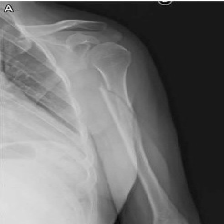

In [95]:
img

In [96]:
x=image.img_to_array(img)
x

array([[[255., 255., 255.],
        [252., 252., 252.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[159., 159., 159.],
        [154., 154., 154.],
        [159., 159., 159.],
        ...,
        [ 59.,  59.,  59.],
        [ 59.,  59.,  59.],
        [ 58.,  58.,  58.]],

       [[148., 148., 148.],
        [142., 142., 142.],
        [146., 146., 146.],
        ...,
        [ 29.,  29.,  29.],
        [ 30.,  30.,  30.],
        [ 31.,  31.,  31.]],

       ...,

       [[219., 219., 219.],
        [218., 218., 218.],
        [219., 219., 219.],
        ...,
        [ 26.,  26.,  26.],
        [ 26.,  26.,  26.],
        [ 26.,  26.,  26.]],

       [[219., 219., 219.],
        [218., 218., 218.],
        [218., 218., 218.],
        ...,
        [ 26.,  26.,  26.],
        [ 26.,  26.,  26.],
        [ 26.,  26.,  26.]],

       [[219., 219., 219.],
        [218., 218., 218.],
        [218., 2

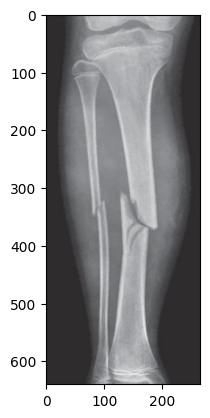

In [97]:
Z = plt.imread('/content/Bones-data/test/Oblique fracture/10-1055-b-002-85516_c023_f003-1_jpg.rf.a2cb46deb0263fc9290f45ee328c632.jpg')
plt.imshow(Z)

In [98]:
x.shape

(224, 224, 3)

In [99]:
x=x/255

In [100]:
from keras.applications.vgg16 import preprocess_input
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)

In [101]:
output = model.predict(img_data)
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


array([[0.00151417, 0.9984858 ]], dtype=float32)

In [102]:
result = np.argmax(output, axis=1)
result

array([1])

In [103]:
if result[0] == 0:
    prediction = 'Oblique fracture'
    print(prediction)
else:
    prediction = 'Spiral Fracture'
    print(prediction)

Spiral Fracture
